# Part.0 EDA

1. 데이터 셋 탐색
2. Sales astype & 단위 조정
3. Dtype 조정
3. 중복치, 결측치 탐색

In [1490]:
import warnings

warnings.filterwarnings(action='ignore')

In [1491]:
import pandas as pd
df = pd.read_csv('/Users/yerin/Downloads/vgames2.csv')

In [1492]:
# unnamed 행 제거
df = df.drop('Unnamed: 0',axis=1)

In [1493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [1494]:
# 2-1 M,K 단위변환

def changing(df: pd.DataFrame, Name: str):
    
    df[Name]=df[Name].str.replace('M','')
    
    k = df[df[Name].str.endswith("K")==True]
    idx = k.index

    df[Name] = df[Name].str.replace("K", "").astype("float")
    df[Name][idx] = df[Name][idx] / 1000
    
changing(df, "NA_Sales")
changing(df, "EU_Sales")
changing(df, "JP_Sales")
changing(df, "Other_Sales")

In [1495]:
# sales 단위 조정 완료

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.1+ MB


In [1496]:
# 4-1: 1개의 중복치 제거

df = df.drop_duplicates()

In [1497]:
# publisher의 결측치는 58개로 Unknown으로 대체한다

df.Publisher.fillna("Unknown",inplace=True)
df.Publisher.isnull().sum()

0

In [1498]:
# Year 결측치, 이상치

ndyn = df.query( '(Name.duplicated() == True) & (Year.isnull()==True)' ).sort_values('Name')

for name in ndyn ['Name'].unique() :
    value = df.loc[df['Name']==name, 'Year'].dropna().first_valid_index()
    if value is not None:
        year = df.loc[value, "Year"]
        df.loc[(df['Name'] == name) & df['Year'].isnull(), 'Year'] = year

In [1499]:
# 그 이후 Year의 결측치는 -1로 대체(지역 별 장르 인기도 분석을 위해 결측치 삭제를 미룬다)

df.Year.fillna(-1,inplace=True)
df.Year.isnull().sum()

0

In [1500]:
# 4-3 이상치 탐색, dtype 조정: Year

Year_error = df.query('-1 < Year < 1000').Year
Year_error_idx = Year_error.index

for i in Year_error_idx:
    if Year_error[i] > 50:
        Year_error[i] = Year_error[i]+1900
    else:
        Year_error[i] = Year_error[i]+2000

Year_error_idx = Year_error.index
df.Year.loc[Year_error_idx] = Year_error

df.Year = df.Year.astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16597 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16597 non-null  object 
 1   Platform     16597 non-null  object 
 2   Year         16597 non-null  int64  
 3   Genre        16547 non-null  object 
 4   Publisher    16597 non-null  object 
 5   NA_Sales     16597 non-null  float64
 6   EU_Sales     16597 non-null  float64
 7   JP_Sales     16597 non-null  float64
 8   Other_Sales  16597 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.8+ MB


In [1501]:
# total Sales column 추가

total = df[['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']]
df['total_Sales']=total.sum(axis=1)

In [1514]:
df_copy = df

In [1503]:
# genre의 결측치는 50개로 극소한 데이터 수이므로 제거한다

df.dropna(subset='Genre',inplace=True)
df.Genre.isnull().sum()

0

In [1504]:
df.Genre.value_counts()

Action          3305
Sports          2341
Misc            1734
Role-Playing    1483
Shooter         1307
Adventure       1280
Racing          1243
Platform         884
Simulation       865
Fighting         847
Strategy         680
Puzzle           578
Name: Genre, dtype: int64

# Part.1  지역에 따른 선호하는 게임 장르
#### 지역에 따라 선호하는 게임 장르가 다를까?
- 지역 구분의 기준
- 지역별 선호하는 게임 장르 파악
- 판단의 기준

#### 1. 지역 구분은 NA(북미), EU(유럽), JP(일본), Other(그 외) 4개로 구분한다

In [1221]:
import matplotlib.pyplot as plt
import seaborn as sns

In [1222]:
df_ratio = pd.DataFrame()

Genre
Action      0.200
Sports      0.156
Shooter     0.133
Platform    0.102
Misc        0.093
Name: NA_Sales, dtype: float64


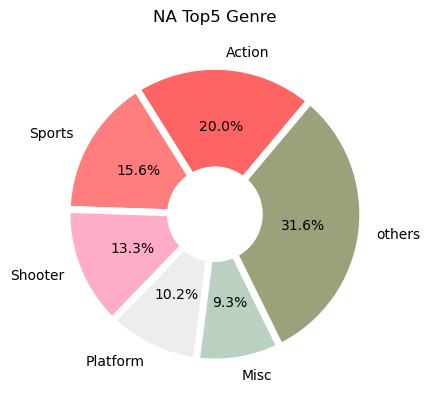

In [1223]:
# 지역별로 장르별 출고량 조사

# NA_Sales

NA_total_Sales = df.NA_Sales.sum()
NA_sum = (df.groupby('Genre')['NA_Sales'].sum().sort_values(ascending=False))
NA_ratio = round(NA_sum/NA_total_Sales,3)
print(NA_ratio.head(5))

ratio = [NA_ratio[0],NA_ratio[1],NA_ratio[2], NA_ratio[3], NA_ratio[4], 1-(NA_ratio.head(5).sum())]
labels = ['Action', 'Sports', 'Shooter', 'Platform','Misc','others']
colors= ['#FF6464', '#FF7D7D', '#FFACC7', '#EDEDED','#BAD1C2','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("NA Top5 Genre")
plt.show()

Genre
Action     0.216
Sports     0.156
Shooter    0.129
Racing     0.098
Misc       0.088
Name: EU_Sales, dtype: float64


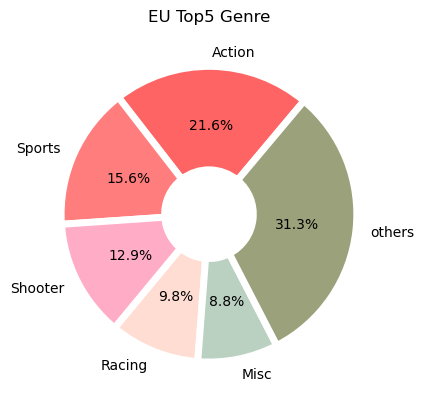

In [1224]:
# EU_Sales

EU_total_Sales = df.EU_Sales.sum()
EU_sum = (df.groupby('Genre')['EU_Sales'].sum().sort_values(ascending=False))
EU_ratio = round(EU_sum/EU_total_Sales,3)
print(EU_ratio.head(5))

ratio = [EU_ratio[0],EU_ratio[1],EU_ratio[2], EU_ratio[3], EU_ratio[4], 1-(EU_ratio.head(5).sum())]
labels = ['Action', 'Sports', 'Shooter', 'Racing','Misc','others']
colors= ['#FF6464', '#FF7D7D', '#FFACC7', '#FFDDD2','#BAD1C2','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("EU Top5 Genre")
plt.show()

Genre
Role-Playing    0.270
Action          0.124
Sports          0.106
Platform        0.102
Misc            0.082
Name: JP_Sales, dtype: float64


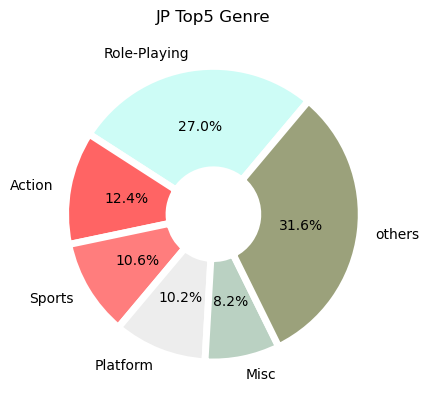

In [1225]:
# JP_Sales

JP_total_Sales = df.JP_Sales.sum()
JP_sum = (df.groupby('Genre')['JP_Sales'].sum().sort_values(ascending=False))
JP_ratio = round(JP_sum/JP_total_Sales,3)
print(JP_ratio.head(5))

ratio = [JP_ratio[0],JP_ratio[1],JP_ratio[2], JP_ratio[3], JP_ratio[4], 1-(JP_ratio.head(5).sum())]
labels = ['Role-Playing', 'Action','Sports', 'Platform','Misc','others']
colors= ['#CDFCF6', '#FF6464', '#FF7D7D', '#EDEDED','#BAD1C2','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("JP Top5 Genre")
plt.show()

Genre
Action     0.235
Sports     0.170
Shooter    0.130
Racing     0.097
Misc       0.093
Name: Other_Sales, dtype: float64


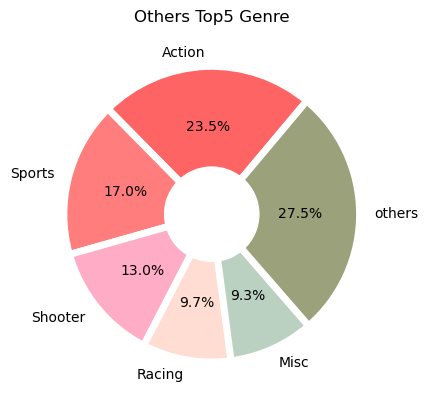

In [1226]:
# Other_Sales

Other_total_Sales = df.Other_Sales.sum()
Other_sum = (df.groupby('Genre')['Other_Sales'].sum().sort_values(ascending=False))

# .nlargest(4)

Other_ratio = round(Other_sum/Other_total_Sales,3)
print(Other_ratio.head(5))

ratio = [Other_ratio[0],Other_ratio[1],Other_ratio[2], Other_ratio[3], Other_ratio[4], 1-(Other_ratio.head(5).sum())]
labels = ['Action', 'Sports', 'Shooter', 'Racing','Misc','others']
colors= ['#FF6464', '#FF7D7D', '#FFACC7', '#FFDDD2','#BAD1C2','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("Others Top5 Genre")
plt.show()

In [1227]:
# 전체 나라에서의 장르별 인기도

t = df.groupby('Genre')['total_Sales','NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
t = t.sort_values(by='total_Sales',ascending=False)

total_Sales = t.total_Sales.sum()
total_ratio = round(t.total_Sales/total_Sales,3)
t['total_ratio'] = total_ratio

t

,total_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_ratio
Genre,,,,,,
Action,1741.32,874.81,522.16,157.90,186.45,0.196
Sports,1327.04,680.52,376.48,135.37,134.67,0.150
Shooter,1035.88,581.92,313.05,38.26,102.65,0.117
Role-Playing,905.03,319.54,183.58,344.95,56.96,0.102
Platform,830.23,446.44,201.61,130.65,51.53,0.094
Misc,799.72,408.05,212.36,105.27,74.04,0.090
Racing,727.79,357.19,237.10,56.40,77.10,0.082
Fighting,448.40,223.20,101.22,87.34,36.64,0.051
Simulation,391.49,182.96,113.35,63.70,31.48,0.044


Genre
Action          0.196
Sports          0.150
Shooter         0.117
Role-Playing    0.102
Platform        0.094
Name: total_Sales, dtype: float64


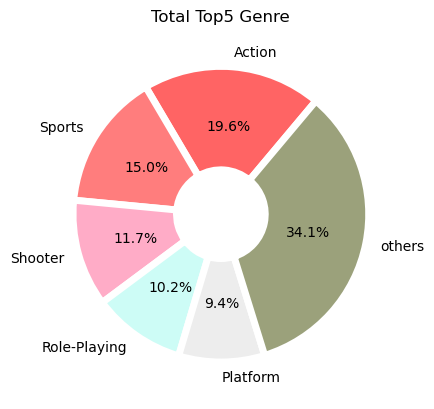

In [1228]:
print(total_ratio.head(5))

ratio = [total_ratio[0],total_ratio[1],total_ratio[2], total_ratio[3], total_ratio[4], 1-(total_ratio.head(5).sum())]
labels = ['Action', 'Sports', 'Shooter', 'Role-Playing','Platform','others']
colors= ['#FF6464', '#FF7D7D', '#FFACC7', '#CDFCF6','#EDEDED','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("Total Top5 Genre")
plt.show()

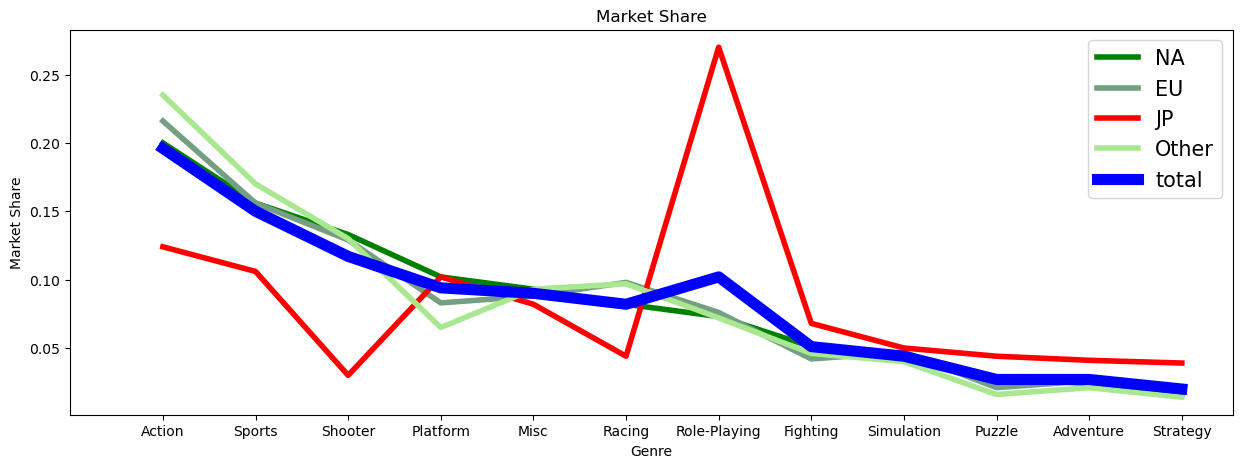

In [1274]:
# 국가별 비교 line plot

NA_ratio = pd.DataFrame(NA_ratio)
EU_ratio = pd.DataFrame(EU_ratio)
JP_ratio = pd.DataFrame(JP_ratio)
Other_ratio = pd.DataFrame(Other_ratio)
total_ratio = pd.DataFrame(total_ratio)

plt.figure(figsize=(15,5))
sns.lineplot(data=NA_ratio, x='Genre',y='NA_Sales', color='g', label="NA", linewidth=4)
sns.lineplot(data=EU_ratio, x='Genre',y='EU_Sales',color='#749F82', label="EU",linewidth=4)
sns.lineplot(data=JP_ratio, x='Genre',y='JP_Sales', color='r', label="JP",linewidth=4)
sns.lineplot(data=Other_ratio, x='Genre',y='Other_Sales',color='#A8E890',label="Other",linewidth=4 )
sns.lineplot(data=total_ratio, x='Genre',y='total_Sales', color='b', label='total',linewidth=8)
plt.ylabel('Market Share')
plt.xlim(-1)
plt.legend(fontsize=15)
plt.title("Market Share")
plt.show()

## Conclusion

- 지역 별 인기도는 지역마다 판매량이 다르므로, 출고량이 아닌 비율을 환산해 계산하여 판단하였다.
- 지역 별 선호하는 장르는 대체로 유사하나, **일본의 경우 Role-Playing의 인기가 유독 많은 것**을 파악했다.
- 그 외 국가는 **Action, Sports, Shooter, Racing-Platform** 순으로 인기가 많은 것을 알 수 있다.
- 전체 국가 기준으로는 Action - Sports - Shooter - Role-Playing - Platform 순으로 인기가 많은 것을 알 수 있다.
- Action or Sports game을 출시할 경우 일본에서의 마케팅보다는 다른 지역에서의 마케팅을 우선적으로 추진한다.


### 단순히 Action, Sports 장르가 많아 출고량도 많은 것이 아닐까?

- Action 장르의 비율은 약 20%, Sports 장르의 비율은 14%이다.
- 이는 인기도에 근접한 수, 따라서 출시량과 출고량이 비례하는 선형관계로 볼 수도 있다.
- 그러나 출시량이 많더라도 인기가 없다면 출고량은 적을 것이다.
- 장르 출시 비율를 넘는 인기도 비율을 가진 국가가 존재한다.
- **JP에서 인기 있는 롤플레잉은 출시 비율(0.08)과 상이하게 27%의 높은 비율로 나타나 유의미한 인사이트라고 할 수 있다.**

In [1230]:
# 추가로 플레이스테이션의 인기 장르를 알아본다.

PS = df.query('(Platform=="PS") or Platform=="PS2" or Platform=="PS3"')
PS = PS.groupby('Genre')['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales','total_Sales'].sum()
PS = PS.sort_values('total_Sales', ascending=False)

PS_total_Sales = PS.total_Sales.sum()
PS_total_ratio = round(PS.total_Sales/PS_total_Sales,3)
PS['total_ratio'] = PS_total_ratio
PS


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales,total_ratio
Genre,,,,,,
Action,310.00,225.92,65.12,101.22,702.26,0.240
Sports,257.21,149.65,51.07,70.33,528.26,0.180
Shooter,160.57,122.41,15.03,45.85,343.86,0.117
Racing,150.78,116.16,19.94,46.24,333.12,0.114
Role-Playing,80.93,50.21,88.76,19.63,239.53,0.082
Fighting,102.86,59.08,32.09,23.03,217.06,0.074
Misc,84.02,60.31,17.72,31.07,193.12,0.066
Platform,85.03,56.33,8.20,17.42,166.98,0.057
Simulation,30.46,20.37,20.48,7.44,78.75,0.027


Genre
Action          0.240
Sports          0.180
Shooter         0.117
Racing          0.114
Role-Playing    0.082
Name: total_Sales, dtype: float64


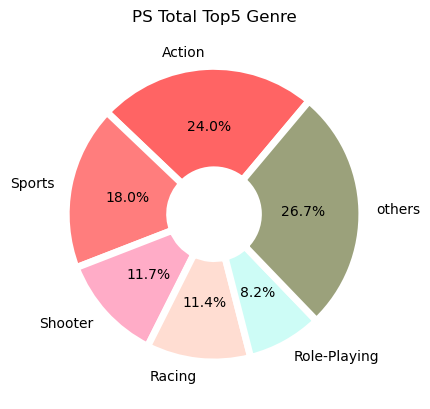

In [1231]:

print(PS_total_ratio.head(5))

ratio = [PS_total_ratio[0],PS_total_ratio[1],PS_total_ratio[2], PS_total_ratio[3], PS_total_ratio[4], 1-(PS_total_ratio.head(5).sum())]
labels = ['Action', 'Sports', 'Shooter', 'Racing','Role-Playing','others']
colors= ['#FF6464', '#FF7D7D', '#FFACC7', '#FFDDD2','#CDFCF6','#9BA17B']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops,startangle=50,)
plt.title("PS Total Top5 Genre")
plt.show()

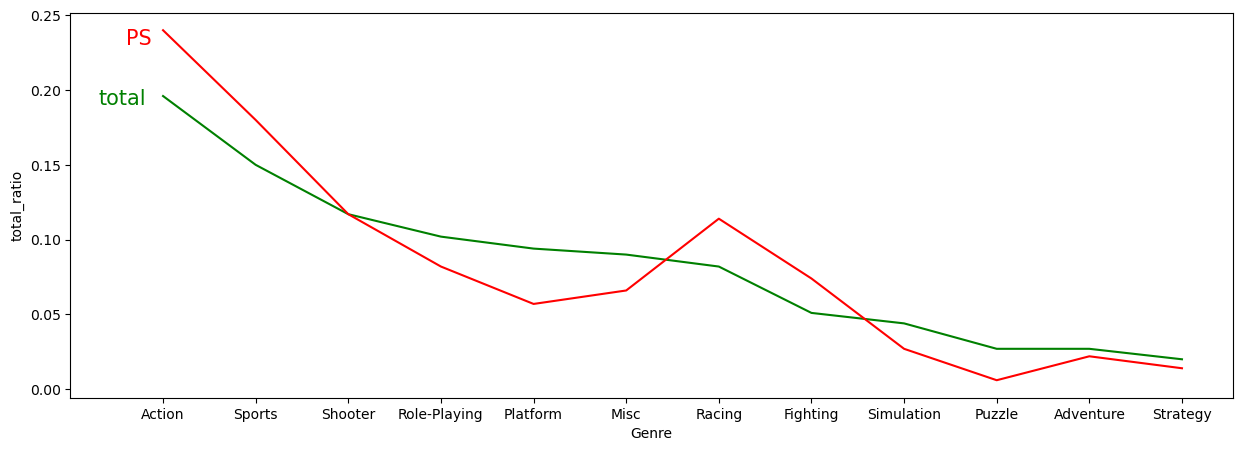

In [1232]:
plt.figure(figsize=(15,5))
sns.lineplot(data=t, x='Genre',y='total_ratio', color='green')
sns.lineplot(data=PS, x='Genre',y='total_ratio',color='red')
plt.xlim(-1)
plt.text(-0.4, 0.23, "PS", color='r',fontsize=15)
plt.text(-0.7, 0.19, "total", color='g',fontsize=15)
plt.show()

In [1234]:
# Sony Computer Entertainment의 PS game Genre 출시량

df.query('(Platform=="PS") or Platform=="PS2" or Platform=="PS3" and Publisher == "Sony Computer Entertainment"').Genre.value_counts()

Sports          637
Action          534
Racing          369
Misc            330
Role-Playing    285
Adventure       270
Shooter         267
Fighting        259
Platform        180
Simulation      153
Strategy        142
Puzzle           50
Name: Genre, dtype: int64

### 플레이스테이션의 인기 비율
- 24%로 Action이 높은 비율을 차지한다.
- Electronic Arts,Sony Computer Entertainment 경우 가장 인기가 많은 장르보다 Sports 장르의 출시가 더 많은 것을 알 수 있다.

# Part.2  연도별 게임 트렌드

- 트렌드 파악의 기준
- 연도별로 트렌드가 존재하나?
- 판단의 기준

In [1235]:
# Year 결측치 삭제

idx = df[df.Year==-1].index
df = df.drop(idx)

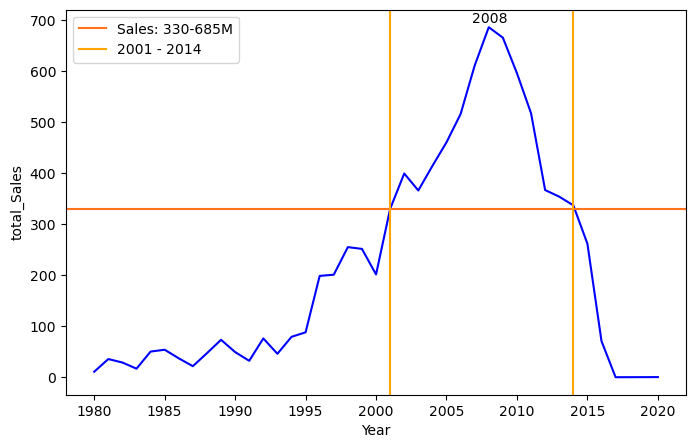

In [1236]:
# 우선 total_Sales를 기준으로 그래프를 그려본다

# Sales graph
total_Year = pd.DataFrame(df.groupby('Year')['total_Sales'].sum())
total_Year['Count'] = df.groupby('Year')['Name'].count()

plt.figure(figsize=(8,5))
sns.lineplot(data = total_Year, x='Year',y='total_Sales',color='b')
plt.text(2006.8, 695, "2008")
plt.axhline(330.11, color='#FF731D', label="Sales: 330-685M")
# plt.axhline(70, color='#B73E3E', label="Sales: 70-330M")
plt.axvline(2001, color='orange', label="2001 - 2014")
plt.axvline(2014, color='orange')
plt.legend();

# Count graph
# plt.figure(figsize=(8,5))
# sns.lineplot(data = total_Year, x='Year',y='Count',color='orange')
# plt.text(2006.8, 1450, "2008");

- 총 출고량은 2001년 부터 2014년 사이 높았으며, 2014년 이후로 출고량이 급감했다.
- https://www.ilovepc.co.kr/news/articleView.html?idxno=12721 "모바일로 순위 변동 일어난 ‘2015년 게임업계 성적표’"
- https://venturebeat.com/games/mobile-games-hit-34-8b-in-2015-taking-85-of-all-app-revenues/ 
"Mobile games hit $34.8B in 2015, taking 85% of all app revenues"
- https://fortune.com/2015/01/15/mobile-console-game-revenues-2015/ "Mobile game revenues set to overtake console games in 2015"
- 모바일 게임 시장이 급성장하게 되며 이외 플랫폼 게임 시장이 하락세를 탄 것으로 추정된다.
- 2001년 전후로 게임 시장이 급성장하게 된 이유도 알아보자.

In [1237]:
# 2001년 이전 플랫폼

df.query('Year < 2001').Platform.value_counts()

PS      1072
N64      303
SNES     239
SAT      173
2600     116
NES       98
GB        87
PS2       82
PC        47
DC        41
GEN       27
NG        12
SCD        6
WS         4
3DO        3
TG16       2
XB         1
GBA        1
DS         1
3DS        1
GG         1
PCFX       1
Name: Platform, dtype: int64

In [1238]:
# 2001년 플랫폼

df.query('(Year == 2001)').Platform.value_counts()

PS2    184
GBA    106
PS      91
XB      35
GC      22
PC      15
GB      10
N64      9
DC       8
WS       2
Name: Platform, dtype: int64

In [1408]:
# 2001년 GBA의 출고량

print("2001년 GBA의 출고량:", df.query('(Year == 2001) and (Platform == "GBA") ').total_Sales.sum())

print("\n2001년 PS2의 출고량:", round( df.query('(Year == 2001) and (Platform == "PS2") ').total_Sales.sum(), 2))
print("2000년 PS2의 출고량:", df.query('(Year == 2000) and ( (Platform == "PS") or (Platform == "PS2") )').total_Sales.sum())


print("\n2001년 전체 출고량:",df.query('(Year == 2001) ').total_Sales.sum())
print("2000년 전체 출고량:",df.query('(Year == 2000) ').total_Sales.sum())

2001년 GBA의 출고량: 61.35

2001년 PS2의 출고량: 163.73
2000년 PS2의 출고량: 135.52

2001년 전체 출고량: 330.11
2000년 전체 출고량: 201.56


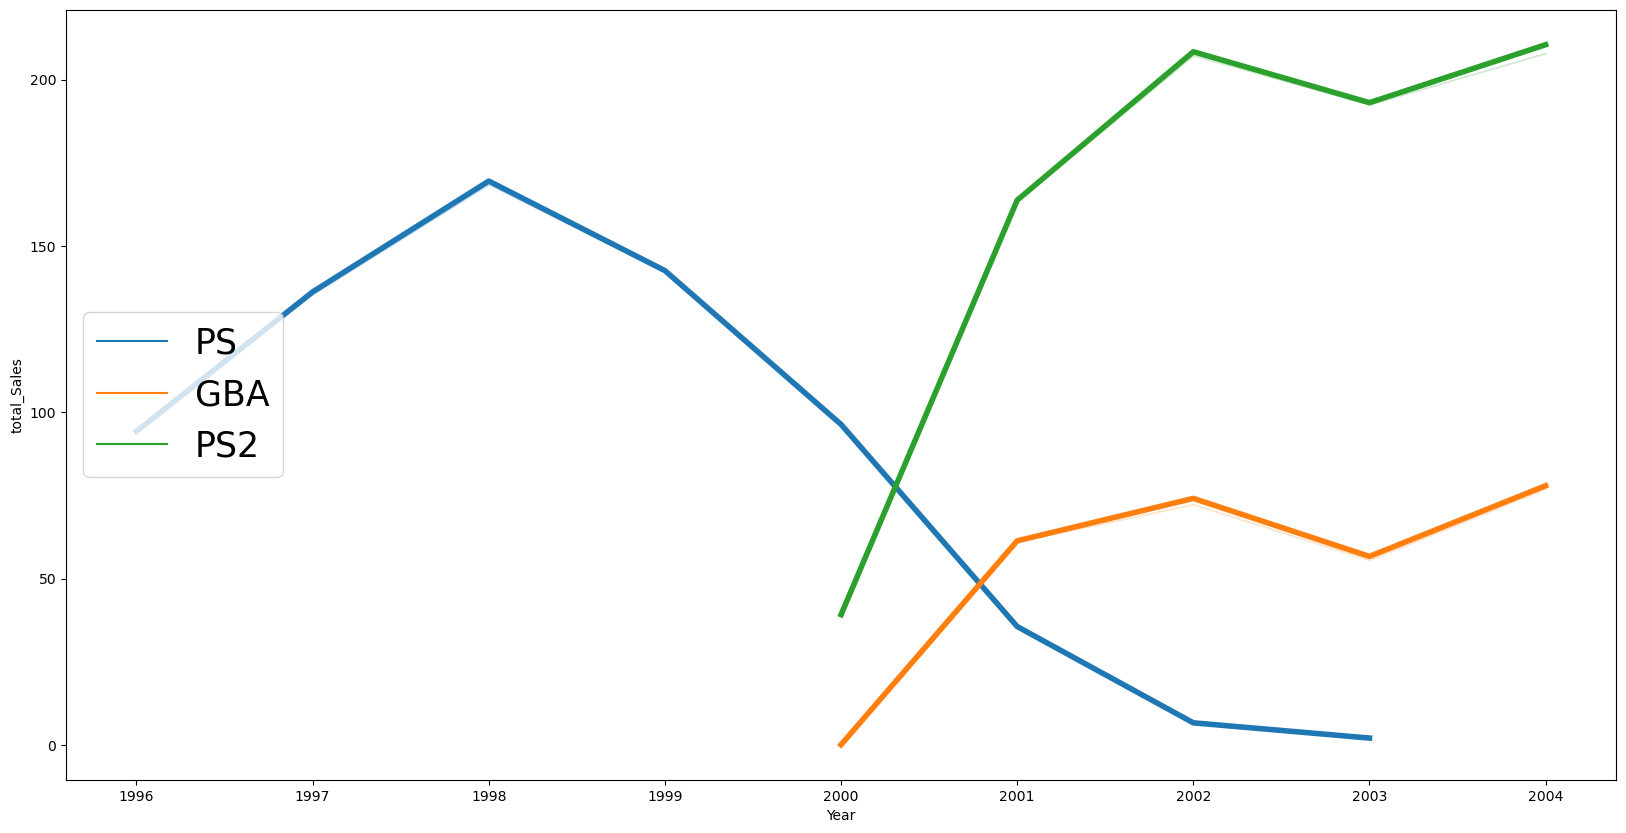

In [1435]:
a201 = df.query('(Year < 2005) and Year > 1995')[['Platform','Year','total_Sales']]
a201 = a201.query('(Platform=="PS") or (Platform=="GBA") or Platform=="PS2"')

a1 = a.groupby(['Platform','Year'])['total_Sales'].sum()

plt.figure(figsize=(20, 10))
sns.lineplot(data=a201, x='Year', y='total_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25);

- GBA는 Nintendo사에서 게임보이 컬러의 후속작으로 출시한 32비트 휴대용 게임기기이다.
- 2001년에 들어서 GBA의 출시가 시작되며 전체 출고량이 130M 가량 늘었으며, 이 중 60M을 차지한다.
- 나머지 시장 점유는 PS2가 160M 가량 차지하고 있는데, 이는 작년 대비 PS1,2 출고량의 30M정도 증가한 수치이다.

#### 즉, 2001년부터 상승세를 타기 시작한 것은 Nintendo사의 GBA출시 영향이 크다고 할 수 있다.
그렇다면 이후 년도 플랫폼 분석을 마저 해보겠다.

In [1243]:
df.query('(Year ==2002 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False).head(5)

Platform
PS2    208.36
GBA     74.11
GC      52.18
XB      49.26
PC       8.57
Name: total_Sales, dtype: float64

In [1244]:
df.query('(Year == 2003 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False).head(5)

Platform
PS2    193.05
GBA     56.67
XB      55.05
GC      50.44
PC       8.96
Name: total_Sales, dtype: float64

In [1245]:
df.query('(Year == 2004 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False).head(5)

Platform
PS2    210.47
GBA     77.91
XB      61.98
GC      28.82
DS      17.41
Name: total_Sales, dtype: float64

In [1246]:
df.query('(Year == 2005 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False).head(5)

Platform
PS2    160.66
DS     131.15
XB      49.09
PSP     43.48
GBA     34.53
Name: total_Sales, dtype: float64

In [1247]:
df.query('(Year == 2006 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False)

Platform
Wii     138.08
DS      121.00
PS2      97.49
PSP      56.53
X360     51.94
PS3      21.06
GC       11.55
XB       10.04
GBA       5.46
PC        2.91
Name: total_Sales, dtype: float64

In [1248]:
df.query('(Year == 2007 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False)

Platform
Wii     155.25
DS      149.32
X360     95.65
PS2      76.10
PS3      73.57
PSP      47.78
PC        9.33
GBA       3.40
XB        0.55
GC        0.27
DC        0.02
Name: total_Sales, dtype: float64

- 2005년부터 DS의 출고량이 급증하더니, 2006년에는 Wii와 더불어 PS2의 출고량을 넘어섰다.

In [1249]:
df.query('(Year == 2008 )').groupby('Platform')['total_Sales'].sum().sort_values(ascending=False)

Platform
Wii     180.53
DS      147.18
X360    136.48
PS3     120.07
PS2      53.29
PSP      36.90
PC       11.69
XB        0.18
DC        0.04
Name: total_Sales, dtype: float64

In [1250]:
# 이를 그래프로 나타낸다.

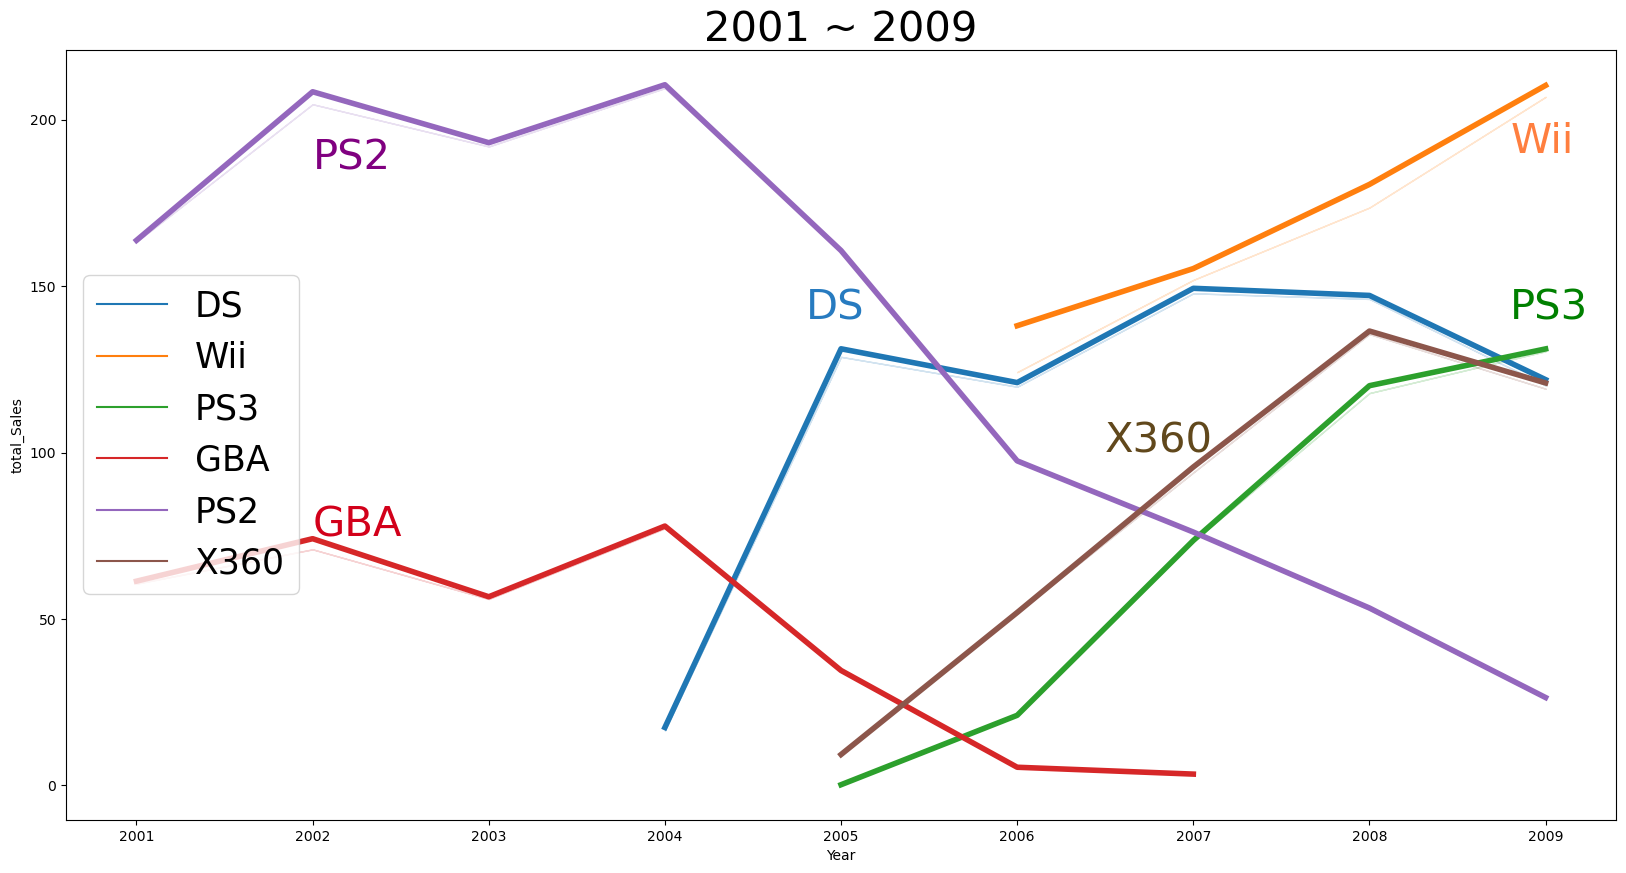

In [1433]:
a = df.query('(Year > 2000) and (Year<2010)')[['Platform','Year','total_Sales']]
a = a.query('(Platform=="DS") or (Platform=="Wii") or (Platform=="PS2") or (Platform=="PS3") or (Platform=="X360") or (Platform=="GBA")')

plt.figure(figsize=(20, 10))
sns.lineplot(data=a, x='Year', y='total_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("2001 ~ 2009", fontsize=30)

plt.text(2002,75,"GBA",fontsize=30, color="#D2001A")
plt.text(2002,185,"PS2",fontsize=30, color="purple")
plt.text(2004.8,140,"DS",fontsize=30, color="#277BC0")
plt.text(2008.8,190,"Wii",fontsize=30, color="#FF7F3F")
plt.text(2008.8,140,"PS3",fontsize=30, color="green")
plt.text(2006.5,100,"X360",fontsize=30, color="#61481C");

### 2009년 이후

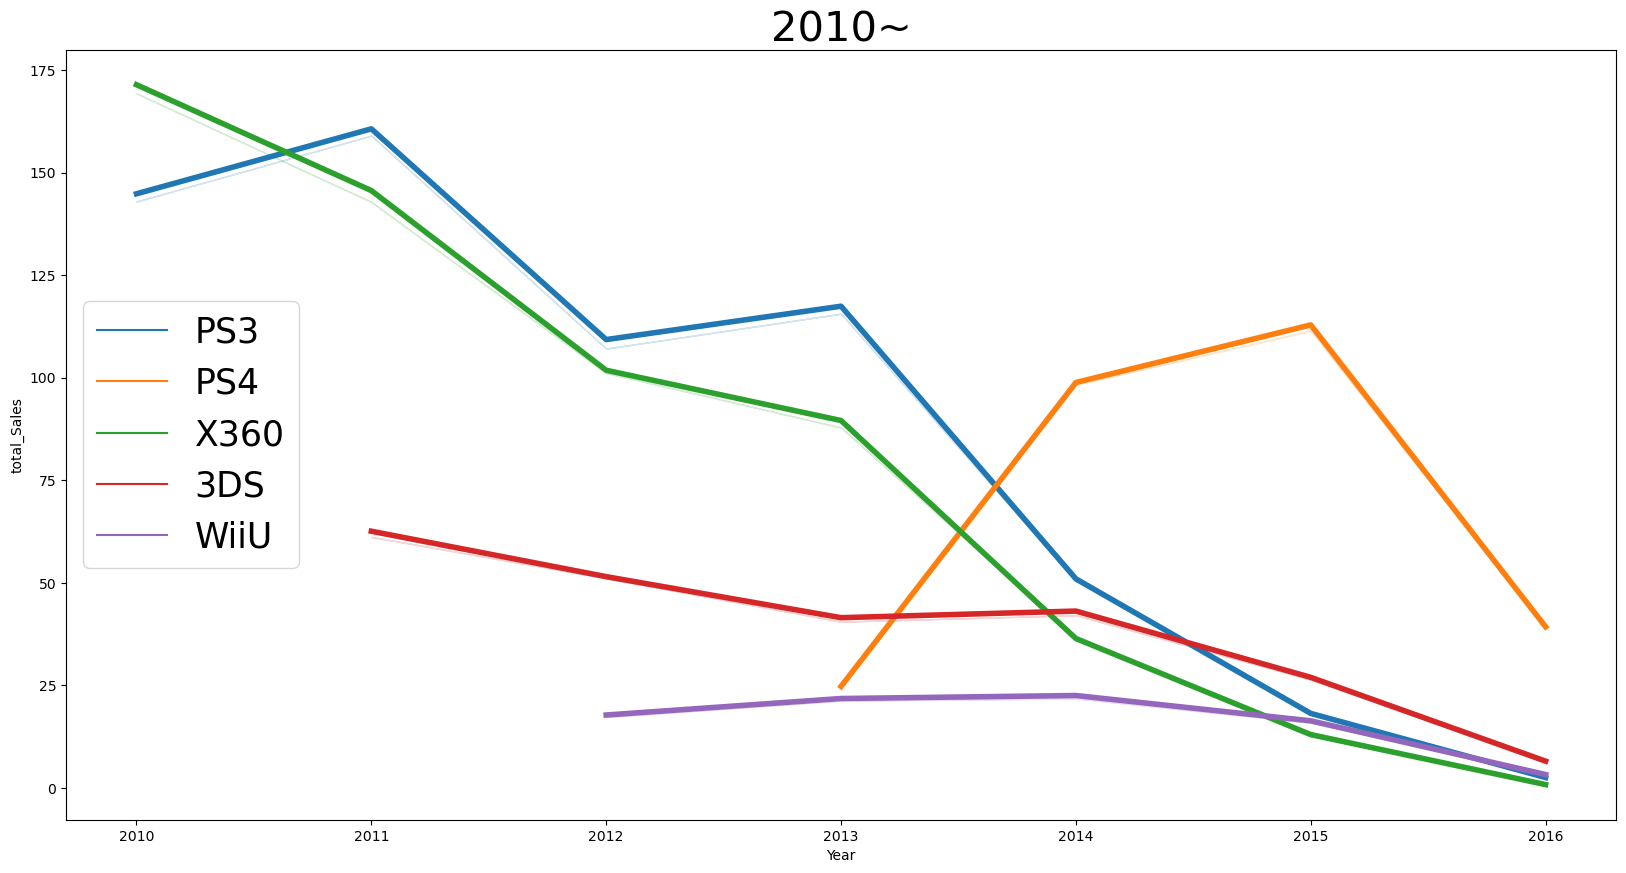

In [1268]:
a209 = df.query('(Year > 2009 and Year < 2017)')[['Platform','Year','total_Sales']]
a209 = a209.query('(Platform=="WiiU") or (Platform=="PS3") or (Platform=="X360") or (Platform=="PS4") or (Platform=="3DS")')

a1 = a.groupby(['Platform','Year'])['total_Sales'].sum()

plt.figure(figsize=(20, 10))
sns.lineplot(data=a209, x='Year', y='total_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("2010~", fontsize=30);

dffdfd = '''plt.text(2002,185,"PS2",fontsize=30, color="#D2001A")
plt.text(2004.8,140,"DS",fontsize=30, color="#277BC0")
plt.text(2008.8,190,"Wii",fontsize=30, color="#FF7F3F")
plt.text(2008.8,140,"PS3",fontsize=30, color="green")
plt.text(2006.5,100,"X360",fontsize=30, color="purple")
plt.text(2002,10,"PS",fontsize=30, color="#594545")'''

- 2009년 이후로는 DS, Wii의 인기가 줄어들고 PS4의 인기가 증가하였다.

### 국가별 분석

Text(0.5, 1.0, 'NA_Sales')

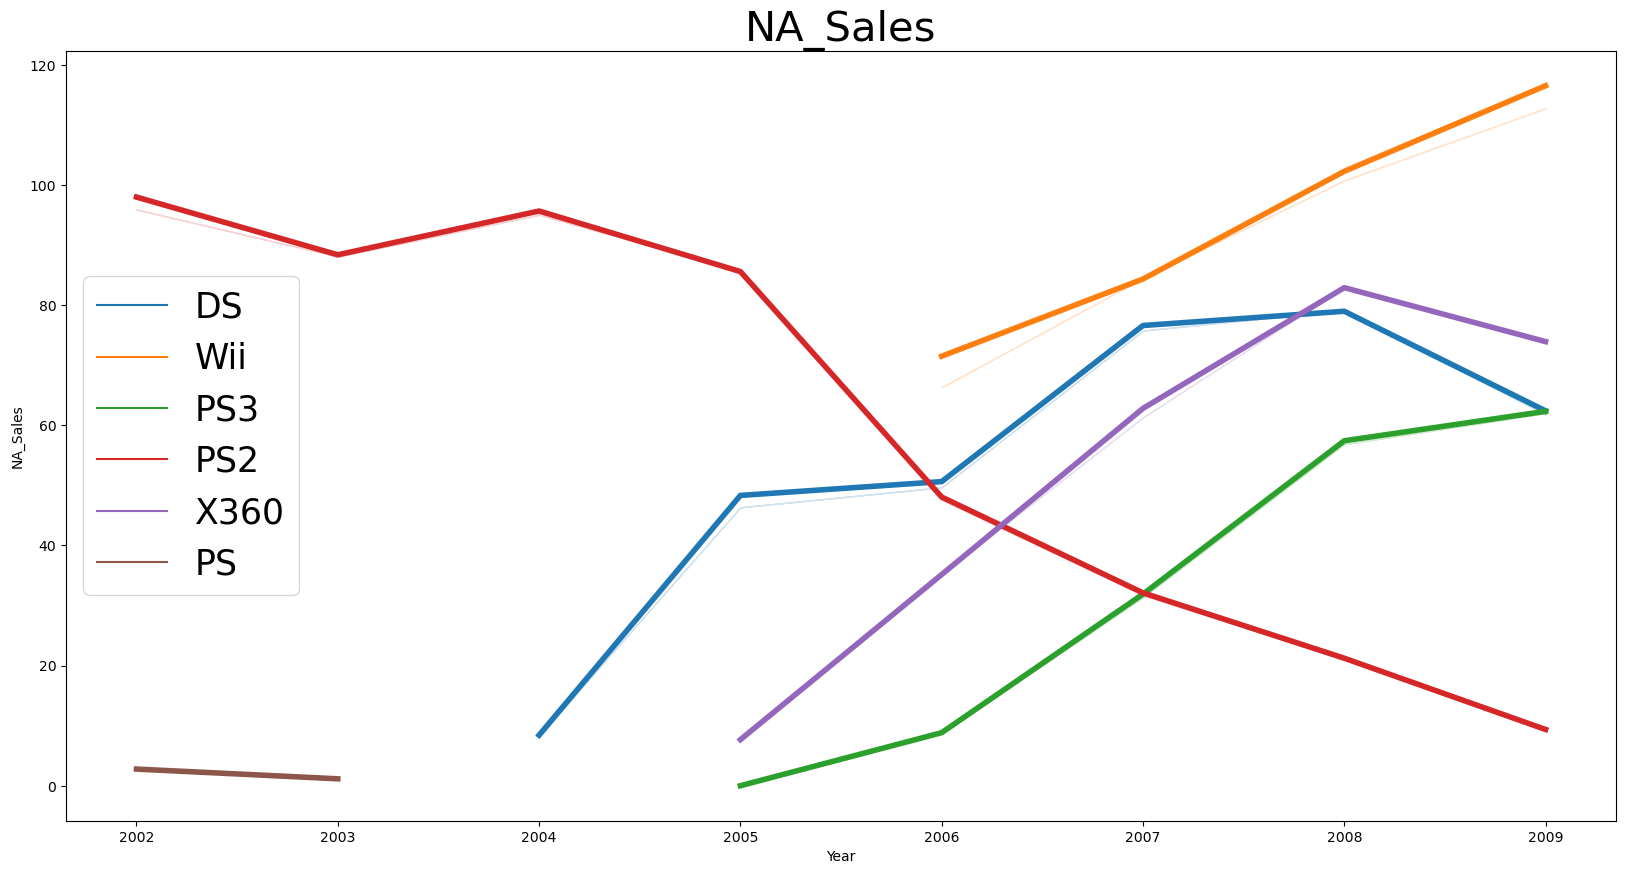

In [1277]:
na = df.query('(Year > 2001) and (Year<2010)')[['Platform','Year','NA_Sales']]
na = na.query('(Platform=="DS") or (Platform=="Wii") or (Platform=="PS") or (Platform=="PS2") or (Platform=="PS3") or (Platform=="X360")')

plt.figure(figsize=(20, 10))
sns.lineplot(data=na, x='Year', y='NA_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("NA_Sales", fontsize=30)

Text(0.5, 1.0, 'EU_Sales')

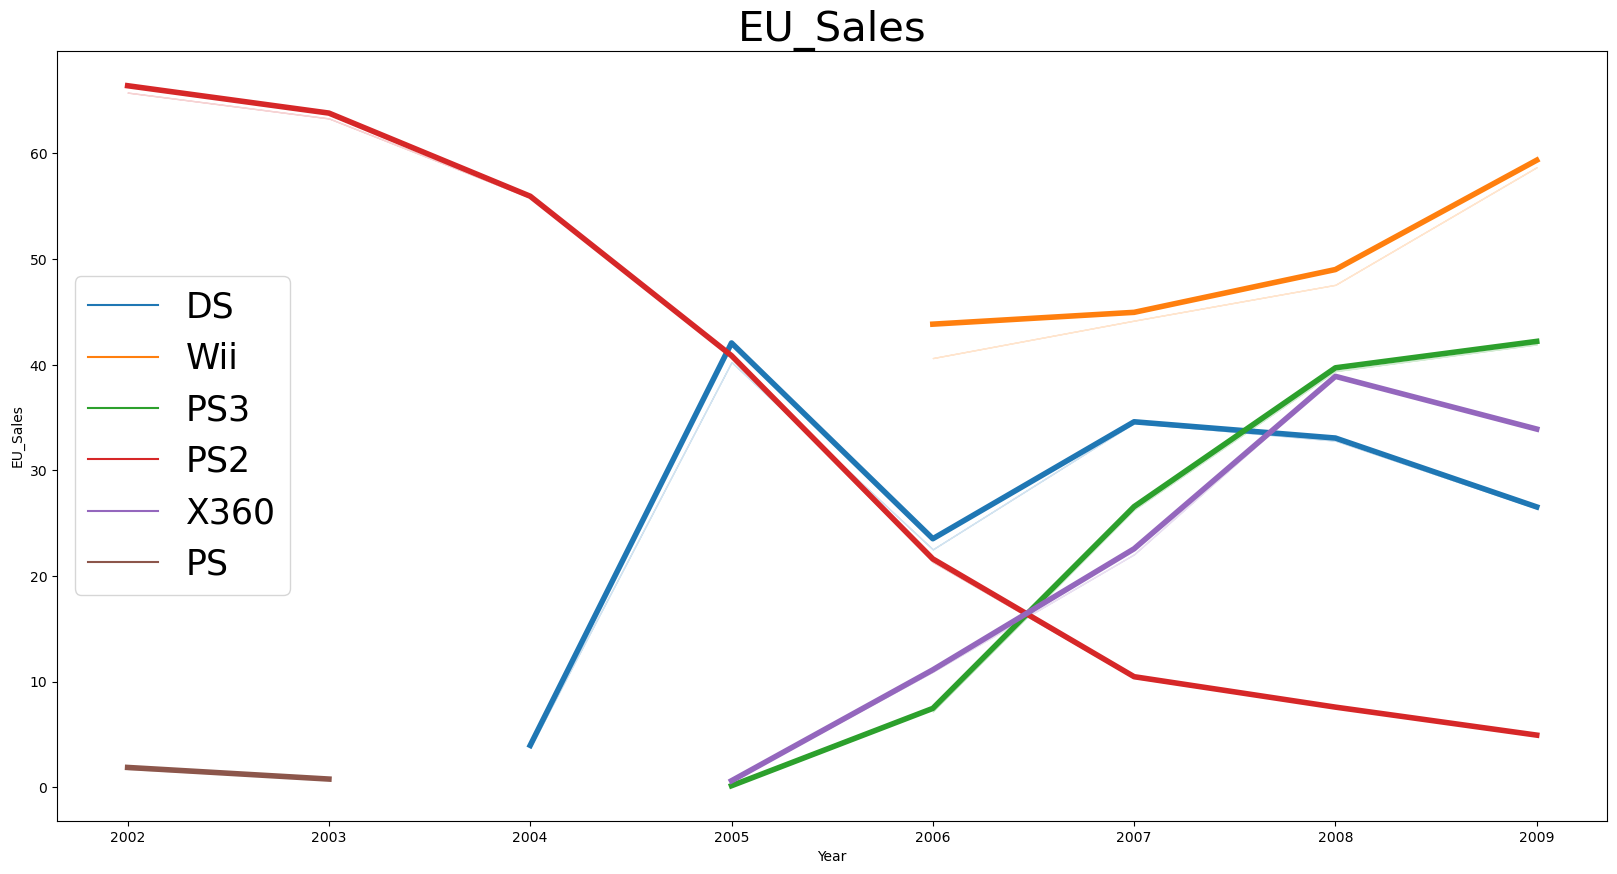

In [1278]:

eu = df.query('(Year > 2001) and (Year<2010)')[['Platform','Year','EU_Sales']]
eu = eu.query('(Platform=="DS") or (Platform=="Wii") or (Platform=="PS") or (Platform=="PS2") or (Platform=="PS3") or (Platform=="X360")')

plt.figure(figsize=(20, 10))
sns.lineplot(data=eu, x='Year', y='EU_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("EU_Sales", fontsize=30)

Text(0.5, 1.0, 'JP_Sales')

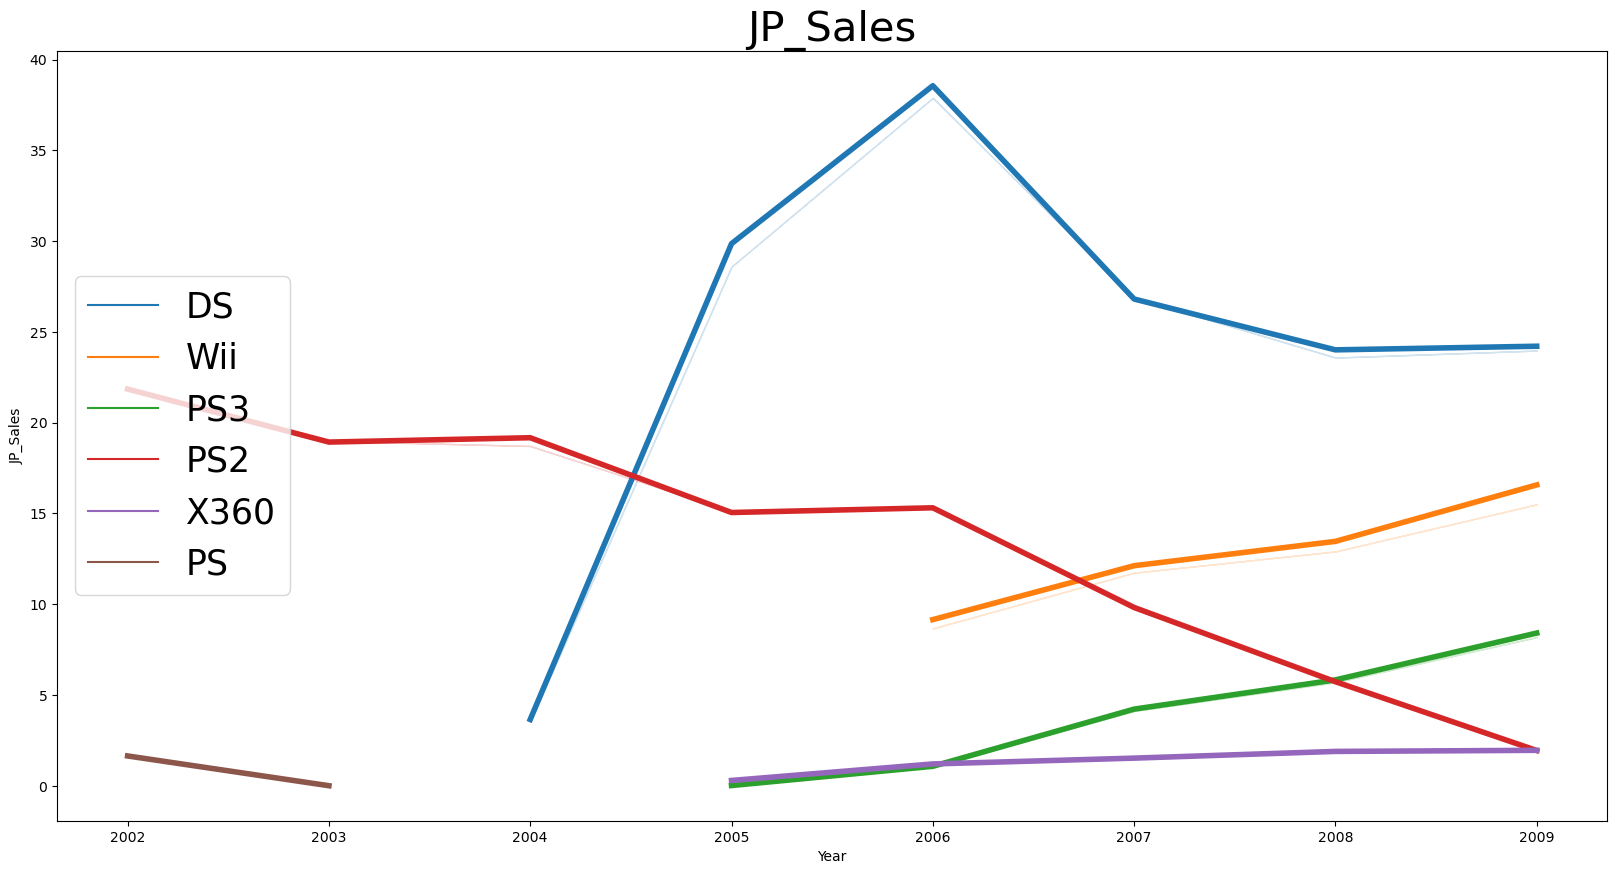

In [1279]:
JP = df.query('(Year > 2001) and (Year<2010)')[['Platform','Year','JP_Sales']]
JP = JP.query('(Platform=="DS") or (Platform=="Wii") or (Platform=="PS") or (Platform=="PS2") or (Platform=="PS3") or (Platform=="X360")')

plt.figure(figsize=(20, 10))
sns.lineplot(data=JP, x='Year', y='JP_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("JP_Sales", fontsize=30)

Text(0.5, 1.0, 'Other Sales')

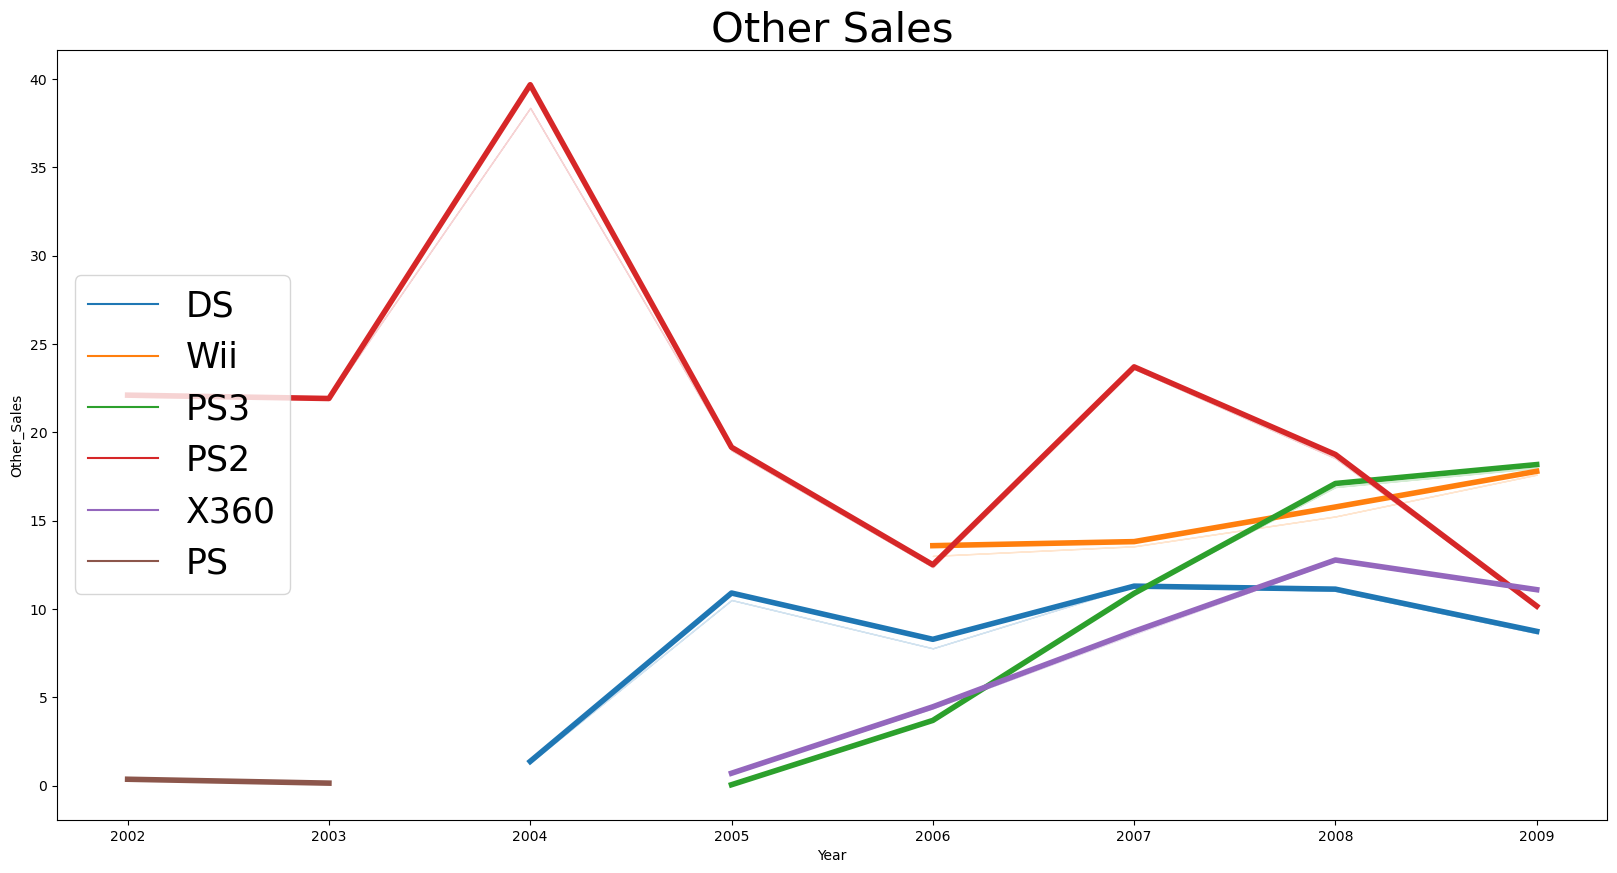

In [1280]:
Other = df.query('(Year > 2001) and (Year<2010)')[['Platform','Year','Other_Sales']]
Other = Other.query('(Platform=="DS") or (Platform=="Wii") or (Platform=="PS") or (Platform=="PS2") or (Platform=="PS3") or (Platform=="X360")')

plt.figure(figsize=(20, 10))
sns.lineplot(data=Other, x='Year', y='Other_Sales', hue='Platform', linewidth=4, estimator='sum',ci = False)
plt.legend(loc='center left', fontsize=25)
plt.title("Other Sales", fontsize=30)

## 장르 분석

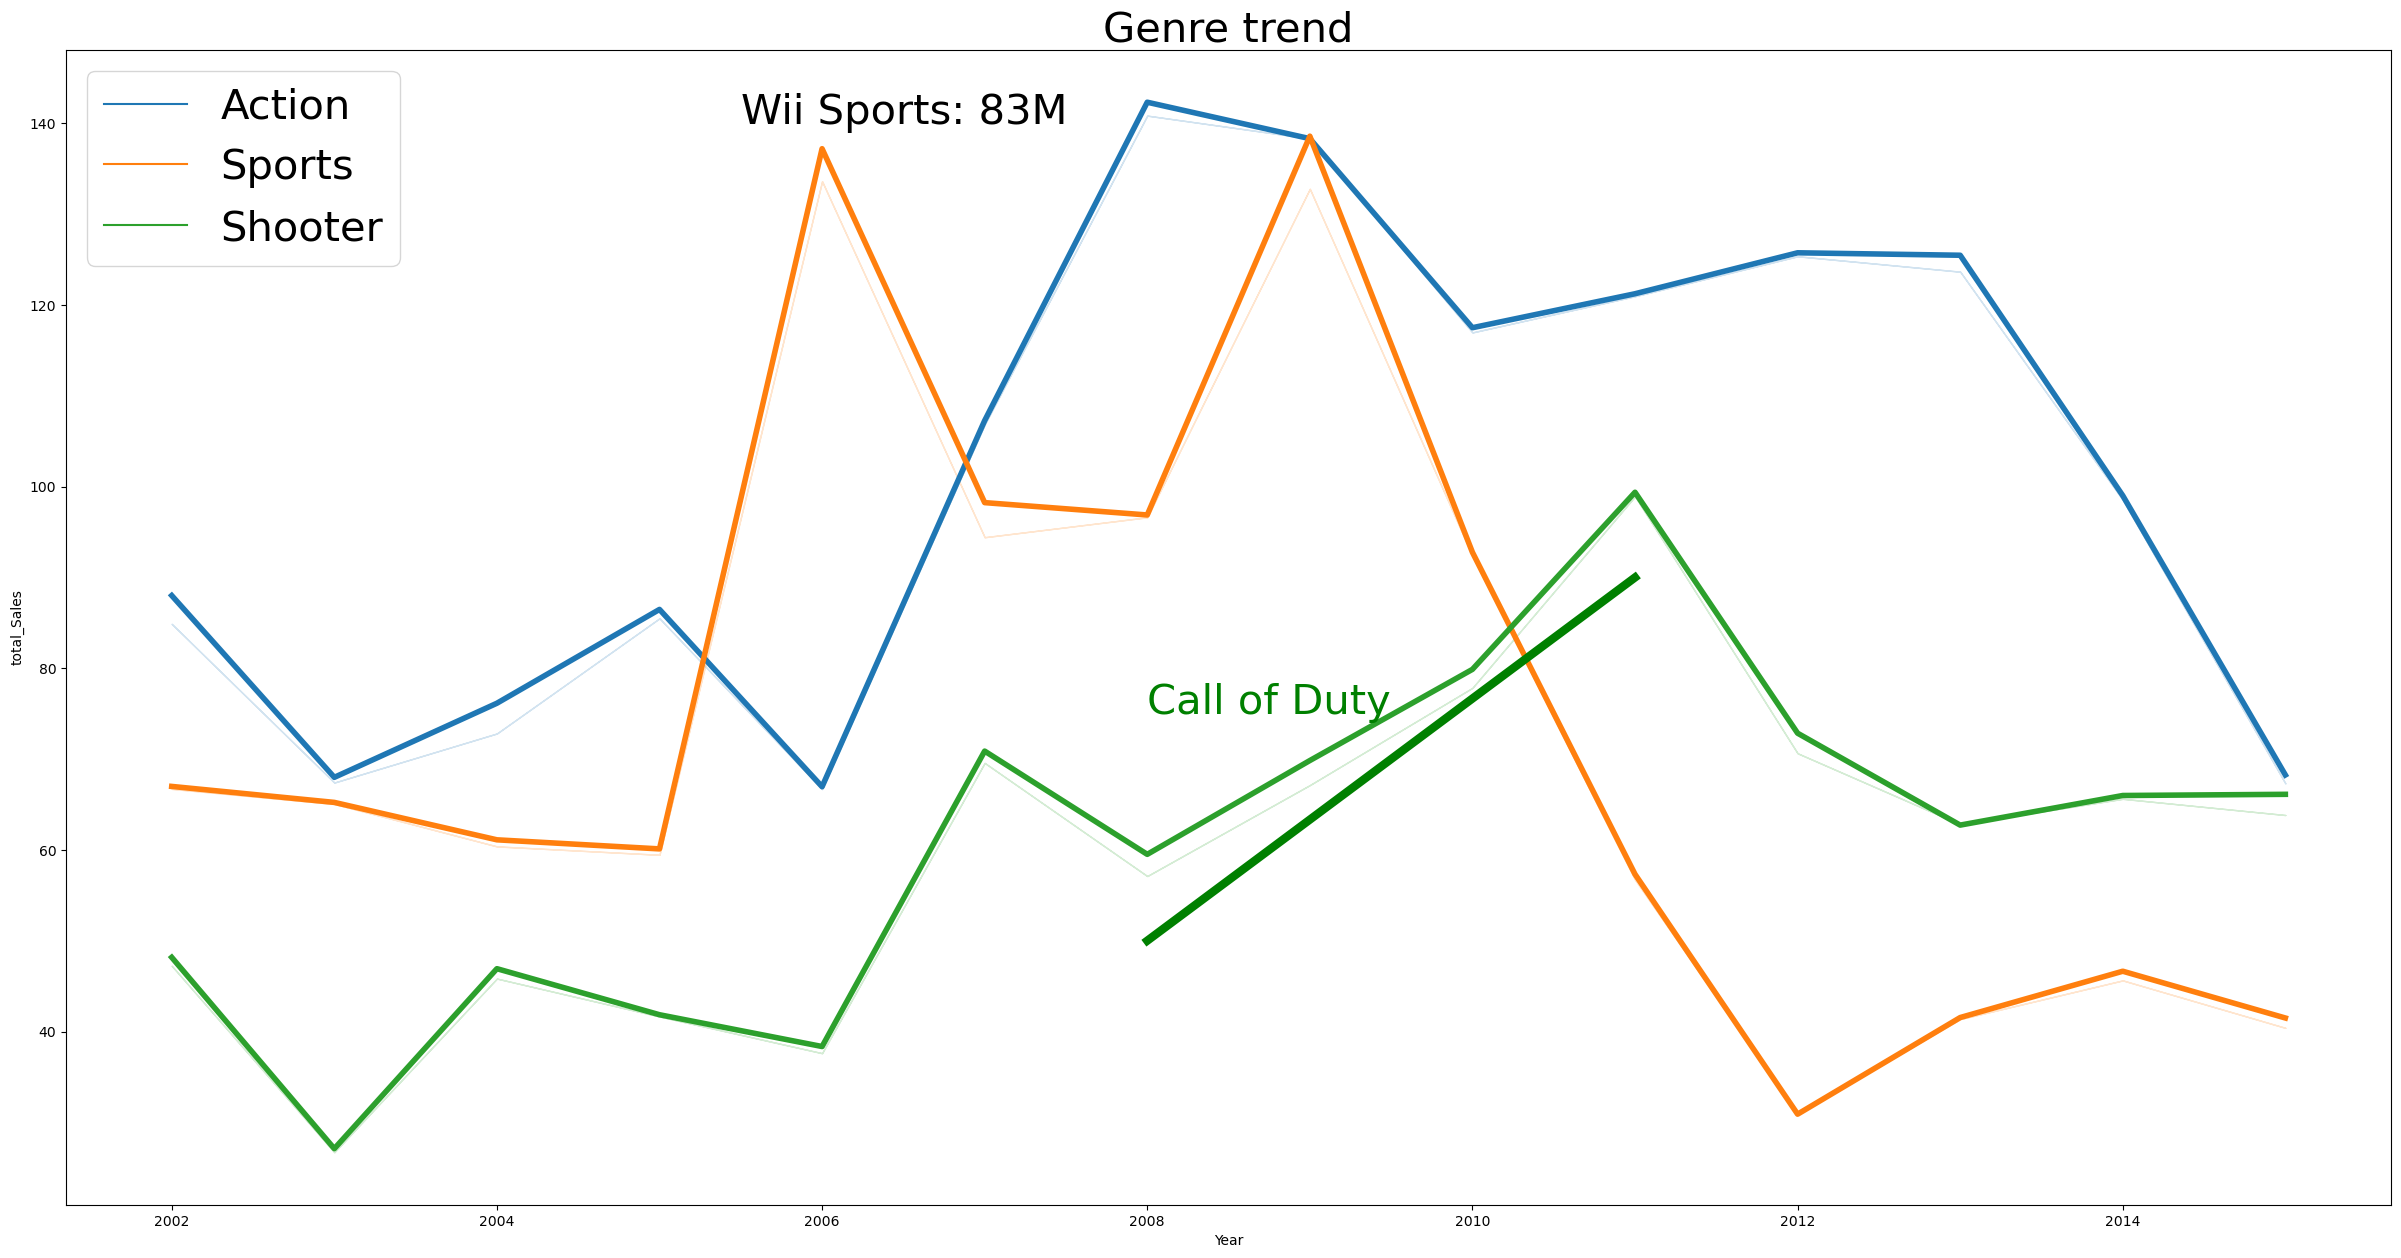

In [1438]:
gy = df.query('(Year > 2001) and (Year < 2016)')[['Genre','Year','total_Sales']]
gy = gy.query('(Genre=="Sports" or Genre=="Action" or Genre=="Shooter")')

plt.figure(figsize=(30, 15))
sns.lineplot(data=gy, x='Year', y='total_Sales', hue='Genre', linewidth=4, estimator='sum',ci = False)
plt.text(2005.5,140,"Wii Sports: 83M", fontsize=30)
plt.text(2008,75,"Call of Duty", fontsize=30, color='green')
plt.plot([2008, 2011], [50, 90], color='green', linewidth=6)
plt.title("Genre trend", fontsize=30)

plt.legend(loc = 'upper left', fontsize=30);

- 출고량이 증가하는 시점은 장르, 플랫폼이 아닌 게임 자체의 인기가 높아질 때로 추측된다.
- 2006년에는 Wii Sports로 Sports 장르의 인기가 치솟았다.
- 2007년부터 꾸준히 증가세를 보인 shooting장르는 Activision사의 Call of Duty의 영향으로 볼 수 있다.

- 따라서 년도에 따른 장르의 트렌드는 있으나 단순히 장르 때문으로 보기는 어렵고, 특정 게임의 유행으로 볼 수 있다.
- 그러나 특정 게임의 유행으로 장기적인 트렌드를 이끌어가는 경향도 존재한다. (Call of Duty)
- Action 장르에서 꾸준히 판매량 1등을 차지하는 것은 GTA

In [931]:
# 2006년 wii Sports

df.query('Year==2006 and Genre=="Sports"').sort_values(by="total_Sales", ascending=False).head(5)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
14918,Madden NFL 07,PS2,2006,Sports,Electronic Arts,3.63,0.24,0.01,0.61,4.49
13026,Winning Eleven: Pro Evolution Soccer 2007,PS2,2006,Sports,Konami Digital Entertainment,0.10,2.39,1.05,0.86,4.40
15591,FIFA Soccer 07,PS2,2006,Sports,Electronic Arts,0.71,2.48,0.03,0.89,4.11
2949,Madden NFL 07,X360,2006,Sports,Electronic Arts,1.66,0.00,0.01,0.13,1.80


In [921]:
# 판매량 best3

df.sort_values(by="total_Sales",ascending=False).head(3)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4199,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83


In [936]:
# Call of Duty

df.query('Year>2006 and Genre=="Shooter"').sort_values(by="total_Sales", ascending=False).head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
6236,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
9924,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73
8374,Call of Duty: Modern Warfare 2,PS3,2009,Shooter,Activision,4.99,3.69,0.38,1.63,10.69
5604,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.72,2.63,0.04,0.82,10.21


In [947]:
df.query('Year==2008 and Genre=="Action"').sort_values(by="total_Sales", ascending=False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total_Sales
13926,Grand Theft Auto IV,X360,2008,Action,Take-Two Interactive,6.76,3.10,0.14,1.03,11.03
16475,Grand Theft Auto IV,PS3,2008,Action,Take-Two Interactive,4.76,3.76,0.44,1.62,10.58
11080,Metal Gear Solid 4: Guns of the Patriots,PS3,2008,Action,Konami Digital Entertainment,2.63,1.74,0.83,0.83,6.03
12392,LEGO Indiana Jones: The Original Adventures,X360,2008,Action,Activision,2.40,1.03,0.00,0.36,3.79
5592,LEGO Batman: The Videogame,X360,2008,Action,Warner Bros. Interactive Entertainment,2.03,1.03,0.00,0.32,3.38
11192,God of War: Chains of Olympus,PSP,2008,Action,Sony Computer Entertainment,1.48,1.01,0.04,0.66,3.19
3347,LEGO Batman: The Videogame,Wii,2008,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
3775,LEGO Batman: The Videogame,DS,2008,Action,Warner Bros. Interactive Entertainment,1.79,1.06,0.00,0.29,3.14
2088,Kung Fu Panda,X360,2008,Action,Activision,1.91,0.84,0.00,0.29,3.04
7703,Saints Row 2,X360,2008,Action,THQ,1.94,0.80,0.02,0.27,3.03


## Conclusion

### 년도별 유행은 존재한다.

- 플랫폼이 게임 시장의 트렌드를 이끈다.
- 장르의 트렌드를 이끄는 것은 특정 게임의 유행이다.

# Part3 인기있는 게임

### 인기가 많은 게임의 정의

- 출고량이 5million 이상
- 연속적인 시즌으로 출시된 게임
- 여러 Platform으로 출시된 게임

#### 분석 기준
- PlayStaion 게임을 기준으로 분석합니다.
- 다음 분기(2018)에 출시하므로 최근 게임을 중점으로 분석합니다.

#### Playstaion 상위권 게임 중 몇 가지를 선별하여 score를 부여합니다.
1. 시즌 1개 당
2. Platform 종류 1개 당
3. 최근 5년 이내 게임 1개 당
4. 출고량 5 million 당

In [1560]:
# 최근 Playstaion 출고량 상위 30

PS = df_copy.query('(Platform=="PS" or Platform=="PS2" or Platform=="PS3" or Platform=="PS2" or Platform=="PS4")').sort_values(by='total_Sales', ascending=False)

In [1561]:
score_list = []
Name_list = []

# score부여 함수

def score(df: pd.DataFrame, Name: str):
    
    score = 0
    
    df1 = PS[PS.Name.str.startswith(Name)==True]
    
    score += len(df1)
    score += len(df1[df1.total_Sales >= 5])
    score += len(df1[df1.total_Sales >= 10])
    score += len(df1[df1.total_Sales >= 15])
    score += len(df1[df1.total_Sales >= 20])
    score += len(df1[df1.Year >= 2013])
    score += len(df_copy[df_copy.Name.str.startswith(Name)==True].Platform.value_counts())-4 # PS개수만 빼줌
    
    score_list.append(score)
    Name_list.append(Name)
    
    return score

# 눈에 띄는 7개의 게임

GTA = score(PS, "Grand Theft Auto")
FIFA = score(PS, "FIFA")
Call_of_Duty = score(PS, "Call of Duty")
Gran_Turismo = score(PS, "Gran Turismo")
Need_For_Speed_Underground = score(PS, "Need for Speed Underground")
Battlefield = score(PS, "Battlefield")
Uncharted = score(PS, "Uncharted")

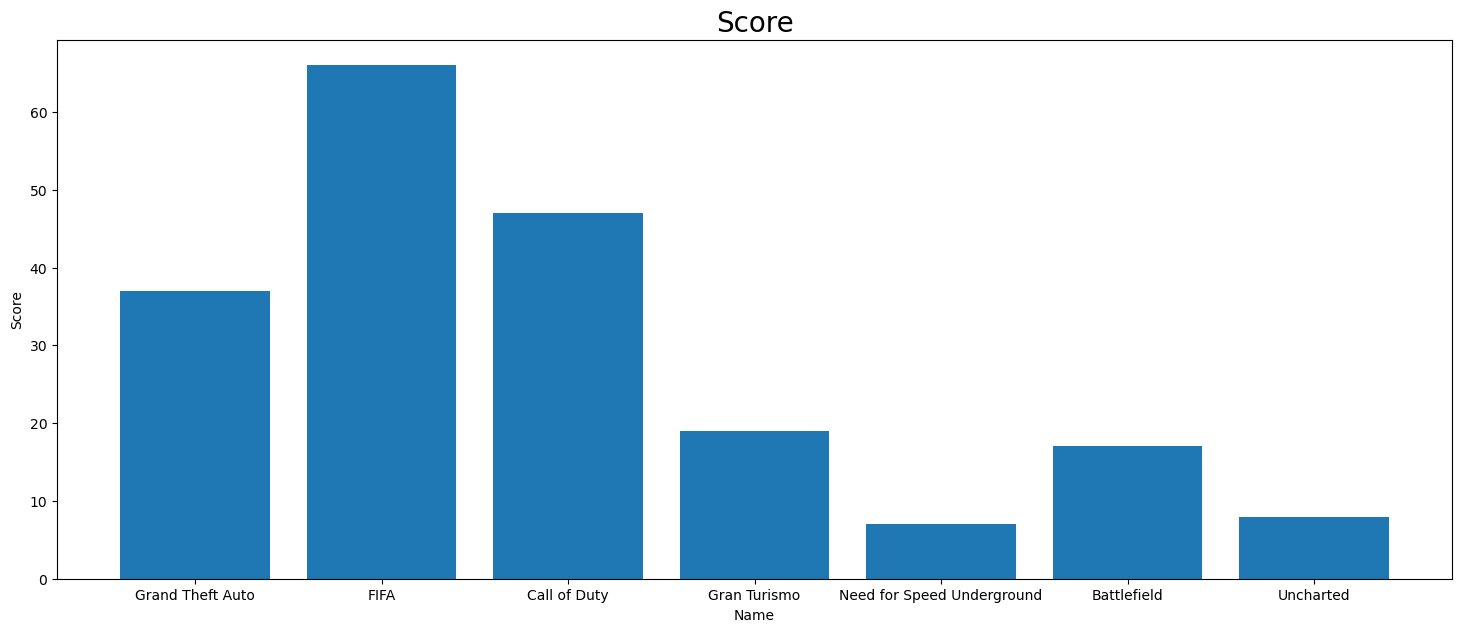

In [1562]:
plt.figure(figsize=(18, 7))
plt.bar(Name_list, score_list)
plt.title("Score", fontsize=20)
plt.xlabel('Name')
plt.ylabel('Score');

In [1563]:
callofdutytotal = df_copy[df_copy.Name.str.startswith("Call of Duty")==True].total_Sales.sum()
GTAtotal = df_copy[df_copy.Name.str.startswith("Grand Theft Auto")==True].total_Sales.sum()
FIFAtotal = df_copy[df_copy.Name.str.startswith("FIFA")==True].total_Sales.sum()

print("Call of Duty total Sales:", round(callofdutytotal))
print("GTA total Sales:", round(GTAtotal))
print("FIFA Sales:", round(FIFAtotal))

Call of Duty total Sales: 247
GTA total Sales: 157
FIFA Sales: 170


### Conclusion

- 인기게임 정의 기준 score을 부여한 결과 Call of Duty가 33점으로 1위, GTA가 32점으로 2위, FIFA가 26점으로 3위를 차지하였다.
- 전체 출고량 또한 Call of Duty가 가장 많았으며, GTA는 FIFA에 비해 전체 출고량이 낮으나 게임 하나 당 Sales가 높아 높은 점수를 얻어 2위를 차지했다.

# 어떤 게임을 출고할 것인가

### Sony Computer Entertainment

- Uncharted 라는 Action게임 시리즈를 출시하고 있으나, 상위 랭크 게임에 현저히 밀리는 상황이다.
- 그러므로 Call of Duty와 함께 꾸준히 증가세를 보이고 있는 Shooting 시리즈를 새롭게 런칭한다.

# 기획배경

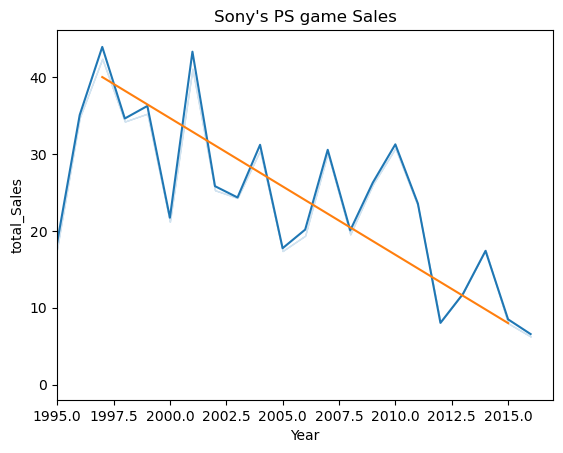

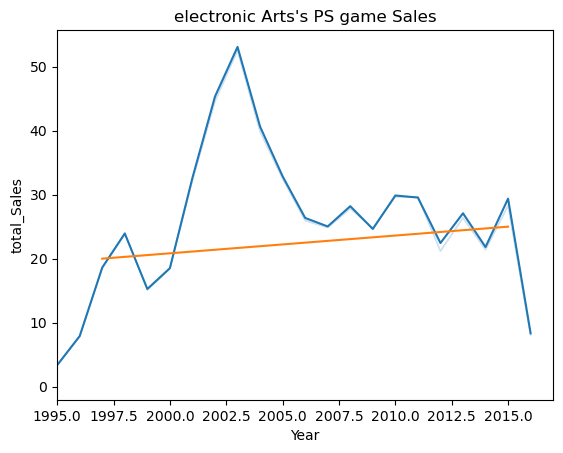

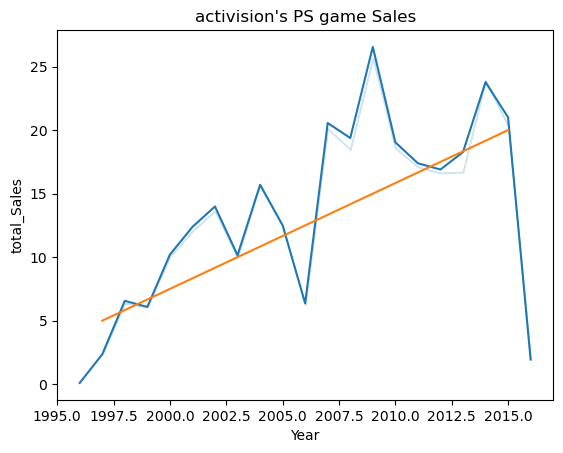

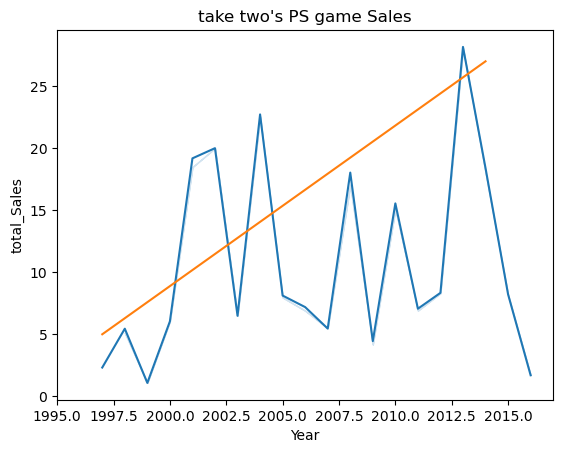

In [1384]:
electronic= df_copy.query('(Platform=="PS" or Platform=="PS2" or Platform=="PS3" or Platform=="PS4" ) and Publisher=="Electronic Arts"').sort_values(by='total_Sales', ascending=False)
activision = df_copy.query('(Platform=="PS" or Platform=="PS2" or Platform=="PS3" or Platform=="PS4" ) and Publisher=="Activision"').sort_values(by='total_Sales', ascending=False)
sony = df_copy.query('(Platform=="PS" or Platform=="PS2" or Platform=="PS3" or Platform=="PS4" ) and Publisher=="Sony Computer Entertainment"').sort_values(by='total_Sales', ascending=False)
take = df_copy.query('(Platform=="PS" or Platform=="PS2" or Platform=="PS3" or Platform=="PS4" ) and Publisher=="Take-Two Interactive"').sort_values(by='total_Sales', ascending=False)

sony_top_20 = sony.sort_values(by='total_Sales', ascending=False).head(20)

sns.lineplot(data=sony, x='Year', y='total_Sales',estimator='sum',ci = False)
plt.xlim(1995, 2017)
plt.plot([1997, 2015], [40, 8])
plt.title("Sony's PS game Sales")
plt.show()

sns.lineplot(data=electronic, x='Year', y='total_Sales',estimator='sum',ci = False)
plt.xlim(1995, 2017)
plt.plot([1997, 2015], [20, 25])
plt.title("electronic Arts's PS game Sales")
plt.show()

sns.lineplot(data=activision, x='Year', y='total_Sales',estimator='sum',ci = False)
plt.xlim(1995, 2017)
plt.plot([1997, 2015], [5, 20])
plt.title("activision's PS game Sales")
plt.show()

sns.lineplot(data=take, x='Year', y='total_Sales',estimator='sum',ci = False)
plt.xlim(1995, 2017)
plt.plot([1997, 2014], [5, 27])
plt.title("take two's PS game Sales")
plt.show()

- Play Staion을 판매하는 회사임에도 불구하고 PS 실적은 낮아지고 있는 추세

Text(0.5, 1.0, 'Gran_Turismo')

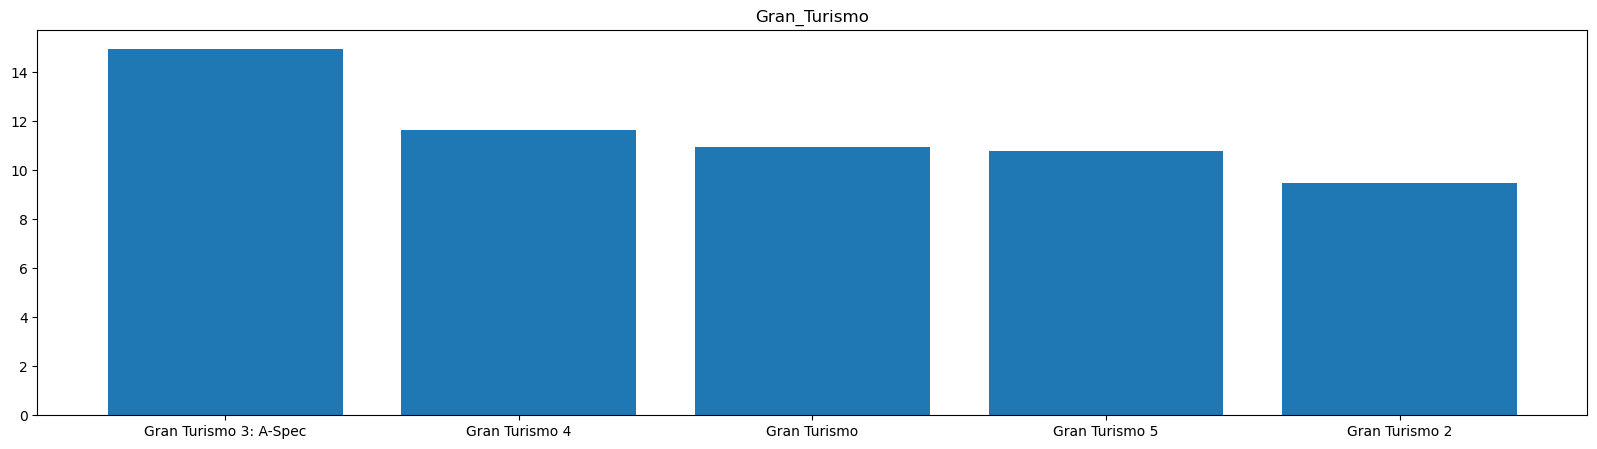

In [1451]:
plt.figure(figsize=(20,5))
plt.bar(PS_Gran_Turismo.Name, PS_Gran_Turismo.total_Sales)
plt.title("Gran_Turismo")

최근에 발매한 Gran Turismo의 인기는 예전만 못하다.